In [64]:
##### import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Activation, Dropout, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [65]:
##### defintion
def build_LSTM_SimpleRNN_model(batch_input_shape1, batch_input_shape2):
    model = Sequential()
    model.add(Bidirectional(LSTM(16, batch_input_shape=(batch_input_shape1, batch_input_shape2), return_sequences=True)))
    model.add(Bidirectional(LSTM(16, activation='tanh', return_sequences=True)))
    model.add(Bidirectional(SimpleRNN(32, activation='tanh', return_sequences=False)))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.add(Activation("linear"))
    return model

In [66]:
data = pd.read_csv('modified_data.csv')

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22303554 entries, 0 to 22303553
Data columns (total 20 columns):
 #   Column               Dtype  
---  ------               -----  
 0   FL_DATE              object 
 1   OP_CARRIER           object 
 2   ORIGIN               object 
 3   DEST                 object 
 4   CRS_DEP_TIME         object 
 5   DEP_DELAY            float64
 6   ARR_DELAY            float64
 7   AIR_TIME             float64
 8   DISTANCE             float64
 9   CARRIER_DELAY        float64
 10  WEATHER_DELAY        float64
 11  NAS_DELAY            float64
 12  SECURITY_DELAY       float64
 13  LATE_AIRCRAFT_DELAY  float64
 14  year                 int64  
 15  month                int64  
 16  day                  int64  
 17  origin               object 
 18  destination          object 
 19  planned departure    float64
dtypes: float64(10), int64(3), object(7)
memory usage: 3.3+ GB


In [68]:
southwest = data[data['OP_CARRIER'] == 'Southwest Airlines']

In [ ]:
southwest['CARRIER_DELAY'] = southwest['CARRIER_DELAY'].apply(lambda x: 0 if x==-1 else x)
southwest['NAS_DELAY'] = southwest['NAS_DELAY'].apply(lambda x: 0 if x==-1 else x)
southwest['WEATHER_DELAY'] = southwest['WEATHER_DELAY'].apply(lambda x: 0 if x==-1 else x)
southwest['SECURITY_DELAY'] = southwest['SECURITY_DELAY'].apply(lambda x: 0 if x==-1 else x)
southwest['LATE_AIRCRAFT_DELAY'] = southwest['LATE_AIRCRAFT_DELAY'].apply(lambda x: 0 if x==-1 else x)

In [70]:
southwest

,FL_DATE,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_DELAY,ARR_DELAY,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,year,month,day,origin,destination,planned departure
1638,2009-01-01,Southwest Airlines,New_Mexico,Texas,afternoon,74.0,68.0,83.0,580.0,3.0,0.0,0.0,0.0,65.0,2009,1,1,ABQ,DAL,1430.0
1639,2009-01-01,Southwest Airlines,New_Mexico,Texas,afternoon,1.0,3.0,82.0,580.0,0.0,0.0,0.0,0.0,0.0,2009,1,1,ABQ,DAL,1640.0
1640,2009-01-01,Southwest Airlines,New_Mexico,Texas,afternoon,2.0,-3.0,81.0,580.0,0.0,0.0,0.0,0.0,0.0,2009,1,1,ABQ,DAL,1250.0
1641,2009-01-01,Southwest Airlines,New_Mexico,Texas,night,4.0,-5.0,77.0,580.0,0.0,0.0,0.0,0.0,0.0,2009,1,1,ABQ,DAL,2020.0
1642,2009-01-01,Southwest Airlines,New_Mexico,Texas,evening,7.0,-1.0,77.0,580.0,0.0,0.0,0.0,0.0,0.0,2009,1,1,ABQ,DAL,1830.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22302367,2018-12-31,Southwest Airlines,Oklahoma,Arizona,afternoon,47.0,47.0,143.0,935.0,7.0,0.0,0.0,0.0,40.0,2018,12,31,TUL,PHX,1350.0
22302368,2018-12-31,Southwest Airlines,Oklahoma,Missouri,morning,11.0,-1.0,47.0,351.0,0.0,0.0,0.0,0.0,0.0,2018,12,31,TUL,STL,620.0
22302369,2018-12-31,Southwest Airlines,Arizona,Nevada,morning,53.0,42.0,58.0,365.0,11.0,0.0,0.0,0.0,31.0,2018,12,31,TUS,LAS,1055.0
22302370,2018-12-31,Southwest Airlines,Arizona,California,afternoon,15.0,12.0,76.0,451.0,0.0,0.0,0.0,0.0,0.0,2018,12,31,TUS,LAX,1210.0


In [71]:
##### sum columns
sw_delay = southwest.groupby(['year', 'month']).sum()

In [72]:
##### count number of flights per day
sw_count = southwest.groupby(['year', 'month'])[['DEP_DELAY']].count()
sw_count.columns = ['count']

In [73]:
##### averaged delayed time per late flight departure
sw_delay['DEP_DELAY_AVG'] = sw_delay['DEP_DELAY']/sw_count['count']
sw_delay['CARRIER_DELAY_AVG'] = sw_delay['CARRIER_DELAY']/sw_count['count']
sw_delay['LATE_AIRCRAFT_DELAY_AVG'] = sw_delay['LATE_AIRCRAFT_DELAY']/sw_count['count']
#sw_delay['WEATHER_DELAY_AVG'] = sw_delay['WEATHER_DELAY']/sw_count['count']
#sw_delay['NAS_DELAY_AVG'] = sw_delay['NAS_DELAY']/sw_count['count']
#sw_delay['SECURITY_DELAY_AVG'] = sw_delay['SECURITY_DELAY']/sw_count['count']

In [74]:
delay_time = pd.DataFrame()
delay_time['DEP_DELAY'] = sw_delay['DEP_DELAY_AVG']
delay_time['CARRIER_DELAY'] = sw_delay['CARRIER_DELAY_AVG']
delay_time['LATE_AIRCRAFT_DELAY'] = sw_delay['LATE_AIRCRAFT_DELAY_AVG']
#delay_time['WEATHER_DELAY_AVG'] = sw_delay['WEATHER_DELAY_AVG']
#delay_time['NAS_DELAY_AVG'] = sw_delay['NAS_DELAY_AVG']
#delay_time['SECURITY_DELAY_AVG'] = sw_delay['SECURITY_DELAY_AVG']

In [75]:
delay_time

DEP_DELAY  CARRIER_DELAY  LATE_AIRCRAFT_DELAY
year month                                               
2009 1      20.212932       3.543319             8.345158
     2      17.453698       3.022255             6.445891
     3      20.054456       3.337217             8.666045
     4      20.601174       3.531028             9.091124
     5      19.964056       3.735917             8.270330
...               ...            ...                  ...
2018 8      27.714130       7.091838            10.659374
     9      23.421262       5.589787             8.179958
     10     22.115006       5.513298             8.070812
     11     23.451521       5.954104             8.551560
     12     25.342073       6.628240             9.649559

[118 rows x 3 columns]

In [76]:
##### normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(delay_time)

In [77]:
#### split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [78]:
##### prepare trainX, trainY, testX, testY
trainX = []
trainY = []

n_future = 1
n_past = 12

for i in range(n_past, len(train) - n_future +1):
    trainX.append(train[i - n_past:i, 0:train.shape[1]])
    trainY.append(train[i + n_future - 1:i + n_future, 0])
trainX, trainY = np.array(trainX), np.array(trainY)

testX = []
testY = []

for i in range(n_past, len(test) - n_future +1):
    testX.append(test[i - n_past:i, 0:test.shape[1]])
    testY.append(test[i + n_future - 1:i + n_future, 0])
testX, testY = np.array(testX), np.array(testY)

In [114]:
##### run model
epoch = 200
number = 5

score=[]
for i in range(number):
    temp =[]
    ##### build model
    model1 = build_LSTM_SimpleRNN_model(trainX.shape[1], trainX.shape[2])

    ##### compile model
    optimizer = Adam(learning_rate=0.0001)
    model1.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
    
    batch_size = 2
    
    ##### fit model
    early_stopping = EarlyStopping(monitor='val_mse', patience=25)
    history = model1.fit(trainX, trainY, epochs=epoch, batch_size=batch_size, validation_data=(testX, testY), verbose=2, shuffle=False, callbacks=[early_stopping])

    ##### make predictions
    trainPredict = model1.predict(trainX, batch_size=batch_size)
    testPredict = model1.predict(testX, batch_size=batch_size)
    
    ##### invert predictions
    trainPredict_copies = np.repeat(trainPredict, train.shape[1], axis=-1)
    y_pred_train = scaler.inverse_transform(trainPredict_copies)[:,0]
    testPredict_copies = np.repeat(testPredict, test.shape[1], axis=-1)
    y_pred_test = scaler.inverse_transform(testPredict_copies)[:,0]
    
    ##### calculate root mean squared error (RMSE) and MAPE
    RMSE_train = math.sqrt(mean_squared_error(delay_time['DEP_DELAY'][12:94].tolist(), y_pred_train))
    print('Train RMSE: %.4f' % (RMSE_train))
    MAPE_train = mean_absolute_percentage_error(delay_time['DEP_DELAY'][12:94].tolist(), y_pred_train)*100
    print('Train MAPE: %.4f' % (MAPE_train))
    RMSE_test = math.sqrt(mean_squared_error(delay_time['DEP_DELAY'][106:].tolist(), y_pred_test))
    print('Test RMSE: %.4f' % (RMSE_test))
    MAPE_test = mean_absolute_percentage_error(delay_time['DEP_DELAY'][106:].tolist(), y_pred_test)*100
    print('Test MAPE: %.4f' % (MAPE_test))

    temp.append(RMSE_train)
    temp.append(MAPE_train)
    temp.append(RMSE_test)
    temp.append(MAPE_test)
    score.append(temp)
print(score)

Train on 82 samples, validate on 12 samples
Epoch 1/200
82/82 - 6s - loss: 0.1105 - mse: 0.1105 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 2/200
82/82 - 1s - loss: 0.0464 - mse: 0.0464 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 3/200
82/82 - 1s - loss: 0.0438 - mse: 0.0438 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 4/200
82/82 - 1s - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 5/200
82/82 - 1s - loss: 0.0433 - mse: 0.0433 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 6/200
82/82 - 1s - loss: 0.0398 - mse: 0.0398 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 7/200
82/82 - 1s - loss: 0.0393 - mse: 0.0393 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 8/200
82/82 - 1s - loss: 0.0310 - mse: 0.0310 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 9/200
82/82 - 1s - loss: 0.0402 - mse: 0.0402 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 10/200
82/82 - 1s - loss: 0.0350 - mse: 0.0350 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 11/200
82/82 - 1s - loss: 0.0378 - mse: 0.0378 - val_loss: 

In [115]:
print(np.mean(score, axis = 0))
print(np.std(score, axis = 0))

[ 2.90335599 10.10964435  1.54044495  4.94308058]
[0.08985283 0.40018182 0.04693557 0.19756942]


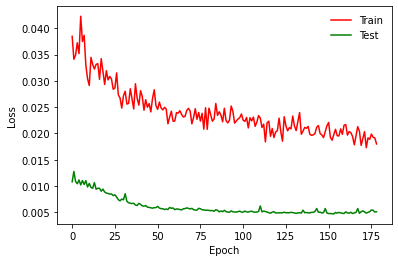

In [116]:
##### graph representative MSE
fig, ax = plt.subplots()
ax.plot(history.history['loss'], color='red')
ax.plot(history.history['val_loss'], color='green')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.legend(['Train', 'Test'], frameon=False)
plt.show()
fig.savefig('mse_multivariate.png')

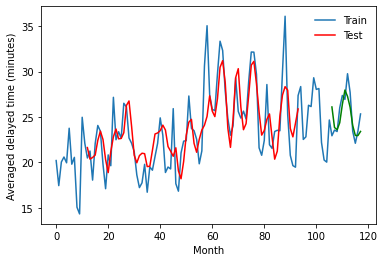

In [117]:
##### plot representative baseline and predictions
fig, ax = plt.subplots()
ax.plot(delay_time['DEP_DELAY'].tolist())
ax.plot(np.arange(12,94), y_pred_train, color='red')
ax.plot(np.arange(106,118), y_pred_test, color='green')
ax.set_xlabel('Month')
ax.set_ylabel('Averaged delayed time (minutes)')
plt.legend(['Train', 'Test'], frameon=False)
plt.show()
fig.savefig('plot_multivariate.png')